In [1]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.optimizers import *
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

from nltk.tokenize import sent_tokenize
from konlpy.corpus import kolaw
from konlpy.tag import Okt # instead of Twitter

## Corpus

In [2]:
c = kolaw.open('constitution.txt').read()

In [3]:
sentents = [s for s in sent_tokenize(c)]
sentents[3]

'제2조 ① 대한민국의 국민이 되는 요건은 법률로 정한다.'

## Preprocessing

In [4]:
okt = Okt()
doc0 = [" ".join(["".join(w) for w, t in okt.pos(s) 
                  if t not in ['Number', "Foreign"] and w not in["제", "조"]]) for s in sent_tokenize(c)] # number, foreign 품사, 제, 조 단어 제외

/Users/imjunghee/anaconda3/lib/python3.7/site-packages/jpype/_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


In [5]:
len(doc0)

357

In [6]:
doc0[3]

'대한민국 의 국민 이 되는 요건 은 법률 로 정 한다 .'

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(doc0)
doc = [l for l in tokenizer.texts_to_sequences(doc0) if len(l) > 1]  # 문장 길이 2이상만 추출하여 labeling

In [10]:
doc[3]

[102, 1, 22, 5, 111, 653, 4, 9, 24, 13, 6]

In [11]:
maxlen = max([len(x) - 1 for x in doc]) # 각 문장 길이의 - 1
vocab_size = len(tokenizer.word_index) + 1 # tokenizer.word_index(단어장) 길이 + 1

In [13]:
maxlen, vocab_size

(187, 1165)

## Data Generation

In [14]:
def generate_data(X, maxlen, vocab_size):
    for sentence in X:
        inputs = []  # X
        targets = []  # Y
        
        for i in range(1, len(sentence)): # 단어수
            inputs.append(sentence[0:i])  # 1~단어수까지 문장 크기별로 단계적으로 input 데이터 생성
            targets.append(sentence[i])  # 마지막 단어로 단계적으로 target 데이터 생성 
        y = np_utils.to_categorical(targets, vocab_size)
        inputs_sequence = sequence.pad_sequences(inputs, maxlen=maxlen)
        yield (inputs_sequence, y)

In [15]:
for i, (x, y) in enumerate(generate_data(doc, maxlen, vocab_size)):
    print("i", i)
    print("x", x.shape, "\n", x)
    print("y", y.shape, "\n", y)
    if i > 1:
        break

i 0
x (187, 187) 
 [[  0   0   0 ...   0   0 102]
 [  0   0   0 ...   0 102  28]
 [  0   0   0 ... 102  28 602]
 ...
 [  0   0 102 ... 647 155   2]
 [  0 102  28 ... 155   2  20]
 [102  28 602 ...   2  20 180]]
y (187, 1165) 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
i 1
x (6, 187) 
 [[  0   0   0 ...   0   0  45]
 [  0   0   0 ...   0  45 439]
 [  0   0   0 ...  45 439 648]
 [  0   0   0 ... 439 648 102]
 [  0   0   0 ... 648 102   4]
 [  0   0   0 ... 102   4 649]]
y (6, 1165) 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
i 2
x (12, 187) 
 [[  0   0   0 ...   0   0 102]
 [  0   0   0 ...   0 102   1]
 [  0   0   0 ... 102   1 440]
 ...
 [  0   0   0 ...  34 651   4]
 [  0   0   0 ... 651   4  22]
 [  0   0   0 ...   4  22 331]]
y (12, 1165) 
 [[0. 1. 0. ... 0. 0. 0.

In [16]:
X = []
Y = []
for x, y in generate_data(doc, maxlen, vocab_size):
    X.append(x)
    Y.append(y)
    
import numpy as np
X = np.concatenate(X)
Y = np.concatenate(Y)

In [18]:
X.shape, Y.shape

((6917, 187), (6917, 1165))

In [19]:
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=maxlen))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(vocab_size, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 187, 100)          116500    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1165)              117665    
Total params: 314,565
Trainable params: 314,565
Non-trainable params: 0
_________________________________________________________________


## Training

In [21]:
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [22]:
%%time
hist = model.fit(X, Y, epochs=500, batch_size=800, verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/500
 - 22s - loss: 6.6906 - acc: 0.0263
Epoch 2/500
 - 21s - loss: 5.8557 - acc: 0.0418
Epoch 3/500
 - 22s - loss: 5.7551 - acc: 0.0458
Epoch 4/500
 - 22s - loss: 5.7318 - acc: 0.0476
Epoch 5/500
 - 21s - loss: 5.7151 - acc: 0.0503
Epoch 6/500
 - 22s - loss: 5.7016 - acc: 0.0473
Epoch 7/500
 - 21s - loss: 5.6751 - acc: 0.0487
Epoch 8/500
 - 22s - loss: 5.6424 - acc: 0.0486
Epoch 9/500
 - 22s - loss: 5.6144 - acc: 0.0496
Epoch 10/500
 - 22s - loss: 5.5854 - acc: 0.0474
Epoch 11/500
 - 21s - loss: 5.5336 - acc: 0.0510
Epoch 12/500
 - 21s - loss: 5.4964 - acc: 0.0510
Epoch 13/500
 - 21s - loss: 5.4652 - acc: 0.0515
Epoch 14/500
 - 21s - loss: 5.4268 - acc: 0.0505
Epoch 15/500
 - 21s - loss: 5.3914 - acc: 0.0518
Epoch 16/500
 - 21s - loss: 5.3381 - acc: 0.0531
Epoch 17/500
 - 21s - loss: 5.3042 - acc: 0.0581
Epoch 18/500
 - 21s - loss: 5.2615 - acc: 0.0653
Epoch 19/500
 - 21s - loss: 5.2241 - acc: 0.0694
Epoch 20/500
 - 21s - loss: 5.

Epoch 162/500
 - 20s - loss: 2.1351 - acc: 0.5210
Epoch 163/500
 - 21s - loss: 2.1333 - acc: 0.5103
Epoch 164/500
 - 20s - loss: 2.1092 - acc: 0.5264
Epoch 165/500
 - 21s - loss: 2.1132 - acc: 0.5213
Epoch 166/500
 - 20s - loss: 2.0891 - acc: 0.5330
Epoch 167/500
 - 20s - loss: 2.0759 - acc: 0.5249
Epoch 168/500
 - 20s - loss: 2.0799 - acc: 0.5260
Epoch 169/500
 - 20s - loss: 2.0645 - acc: 0.5296
Epoch 170/500
 - 20s - loss: 2.0686 - acc: 0.5275
Epoch 171/500
 - 20s - loss: 2.0294 - acc: 0.5401
Epoch 172/500
 - 20s - loss: 2.0254 - acc: 0.5400
Epoch 173/500
 - 20s - loss: 2.0227 - acc: 0.5395
Epoch 174/500
 - 20s - loss: 2.0173 - acc: 0.5445
Epoch 175/500
 - 20s - loss: 2.0082 - acc: 0.5403
Epoch 176/500
 - 20s - loss: 1.9912 - acc: 0.5440
Epoch 177/500
 - 21s - loss: 1.9888 - acc: 0.5458
Epoch 178/500
 - 21s - loss: 1.9843 - acc: 0.5508
Epoch 179/500
 - 20s - loss: 1.9711 - acc: 0.5466
Epoch 180/500
 - 20s - loss: 1.9501 - acc: 0.5540
Epoch 181/500
 - 21s - loss: 1.9469 - acc: 0.5602


Epoch 326/500
 - 21s - loss: 1.0861 - acc: 0.7463
Epoch 327/500
 - 21s - loss: 1.0671 - acc: 0.7464
Epoch 328/500
 - 21s - loss: 1.0571 - acc: 0.7474
Epoch 329/500
 - 21s - loss: 1.0608 - acc: 0.7396
Epoch 330/500
 - 21s - loss: 1.0483 - acc: 0.7432
Epoch 331/500
 - 21s - loss: 1.0634 - acc: 0.7450
Epoch 332/500
 - 21s - loss: 1.0579 - acc: 0.7405
Epoch 333/500
 - 21s - loss: 1.0538 - acc: 0.7461
Epoch 334/500
 - 21s - loss: 1.0531 - acc: 0.7434
Epoch 335/500
 - 21s - loss: 1.0529 - acc: 0.7467
Epoch 336/500
 - 21s - loss: 1.0525 - acc: 0.7370
Epoch 337/500
 - 21s - loss: 1.0263 - acc: 0.7570
Epoch 338/500
 - 21s - loss: 1.0401 - acc: 0.7471
Epoch 339/500
 - 21s - loss: 1.0385 - acc: 0.7495
Epoch 340/500
 - 21s - loss: 1.0349 - acc: 0.7531
Epoch 341/500
 - 21s - loss: 1.0328 - acc: 0.7450
Epoch 342/500
 - 21s - loss: 1.0397 - acc: 0.7480
Epoch 343/500
 - 21s - loss: 1.0171 - acc: 0.7526
Epoch 344/500
 - 21s - loss: 1.0210 - acc: 0.7513
Epoch 345/500
 - 21s - loss: 1.0158 - acc: 0.7541


Epoch 490/500
 - 21s - loss: 0.7151 - acc: 0.8207
Epoch 491/500
 - 21s - loss: 0.6911 - acc: 0.8269
Epoch 492/500
 - 21s - loss: 0.6946 - acc: 0.8248
Epoch 493/500
 - 21s - loss: 0.6880 - acc: 0.8282
Epoch 494/500
 - 21s - loss: 0.6904 - acc: 0.8261
Epoch 495/500
 - 21s - loss: 0.6751 - acc: 0.8269
Epoch 496/500
 - 21s - loss: 0.6815 - acc: 0.8258
Epoch 497/500
 - 21s - loss: 0.6686 - acc: 0.8306
Epoch 498/500
 - 21s - loss: 0.6701 - acc: 0.8271
Epoch 499/500
 - 21s - loss: 0.6915 - acc: 0.8225
Epoch 500/500
 - 21s - loss: 0.6727 - acc: 0.8267
CPU times: user 7h 21min 13s, sys: 1h 44min 43s, total: 9h 5min 56s
Wall time: 2h 53min 37s


In [23]:
import warnings
warnings.filterwarnings(action='ignore')

import matplotlib.pylab as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 12

path = "/Library/Fonts/NanumGothic.otf"
font_name = fm.FontProperties(fname=path, size=20).get_name()

plt.rc('font', family=font_name)
fm._rebuild()

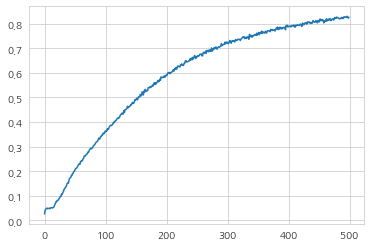

In [24]:
plt.plot(hist.history['acc'])
plt.show()

In [28]:
model.save("rnn_text_gen.hdf5")

## Test

In [29]:
from keras.models import load_model
model = load_model("rnn_text_gen.hdf5")

In [30]:
word_list = '대한민국 의 국민 이 되는 요건 은 법률 로 정한 다 .'.split(" ")
word_list

['대한민국', '의', '국민', '이', '되는', '요건', '은', '법률', '로', '정한', '다', '.']

In [31]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

In [38]:
#tokenizer.word_index.items()  # dict_items
len(reverse_word_map)

1164

In [39]:
x = sequence.pad_sequences([[tokenizer.word_index[w] for w in word_list[:2]]], maxlen=maxlen)
x

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0

In [40]:
p = model.predict(x)[0]
p

array([1.6181289e-07, 6.1316392e-04, 2.3535850e-04, ..., 4.0190684e-05,
       1.6508386e-07, 9.7588327e-06], dtype=float32)

In [42]:
idx = np.flip(np.argsort(p), 0)  # np.flip : reverse the order of elements along the axis 0 : 정렬하고 순서 바꾸기
idx

array([440, 441,  22, ..., 451,  79, 862])

In [43]:
p[idx]

array([2.6736999e-01, 1.6050121e-01, 5.9015386e-02, ..., 2.8686997e-10,
       2.8458977e-10, 1.2387076e-10], dtype=float32)

In [44]:
for i in idx[:5]:
    print(reverse_word_map[i])

주권
영토
국민
모든
종목


In [45]:
def predict_word(i, n=1):
    x = sequence.pad_sequences([[tokenizer.word_index[w] for w in word_list[:i]]], maxlen=maxlen)
    p = model.predict(x)[0]
    idx = np.flip(np.argsort(p), 0)
    for j in idx[:n]:
        print('"', " ".join(word_list[:i]), '"', reverse_word_map[j], " (p={:4.2f}%)".format(100 * p[j]))

In [46]:
predict_word(1, n=3)

" 대한민국 " 의  (p=48.06%)
" 대한민국 " 은  (p=46.70%)
" 대한민국 " 과  (p=1.25%)


In [47]:
predict_word(2, n=3)

" 대한민국 의 " 주권  (p=26.74%)
" 대한민국 의 " 영토  (p=16.05%)
" 대한민국 의 " 국민  (p=5.90%)


In [48]:
predict_word(3, n=3)

" 대한민국 의 국민 " 이  (p=37.99%)
" 대한민국 의 국민 " 은  (p=29.38%)
" 대한민국 의 국민 " 경제  (p=17.25%)


In [49]:
predict_word(4, n=3)

" 대한민국 의 국민 이 " 되는  (p=44.46%)
" 대한민국 의 국민 이 " 헌법  (p=30.39%)
" 대한민국 의 국민 이 " 생활  (p=5.49%)


In [50]:
predict_word(5, n=3)

" 대한민국 의 국민 이 되는 " 요건  (p=97.85%)
" 대한민국 의 국민 이 되는 " 되는  (p=0.83%)
" 대한민국 의 국민 이 되는 " 은  (p=0.25%)


In [52]:
predict_word(9, n=3)

" 대한민국 의 국민 이 되는 요건 은 법률 로 " 정  (p=99.59%)
" 대한민국 의 국민 이 되는 요건 은 법률 로 " 그  (p=0.12%)
" 대한민국 의 국민 이 되는 요건 은 법률 로 " 한다  (p=0.08%)


In [54]:
def generate(w, n, seed=None):
    if seed is not None:
        np.random.seed(seed)
    def _predict_word(sent):
        x = sequence.pad_sequences([[tokenizer.word_index[w] for w in sent]], maxlen=maxlen)
        p = model.predict(x)[0]
        logp = np.log(p)
        p = np.exp(logp) / np.sum(np.exp(logp))
        p = p[1:]
        return np.random.choice(list(tokenizer.word_index.keys()), p=p)
    
    sent = []
    for i in range(n):
        w = _predict_word(sent)
        sent.append(w)
        
    return " ".join(sent)

In [55]:
generate("대한민국", 10, seed=1)

'국민 경제 의 발전 을 위 한 중요 정책 의'

In [56]:
generate("대한민국", 10, seed=2)

'국민 의 목적 을 육성 하며 때 에는 법률 이'

In [57]:
generate("대한민국", 10, seed=3)

'국민 경제 의 발전 을 위 한 조약 의 제정'

In [58]:
generate("대한민국", 10, seed=4)

'감사원 은 세입 · 세 출의 결산 을 매년 검사'

In [59]:
generate("대한민국", 10, seed=5)

'대통령 은 법률 이 정 하는 바 에 의하여 국가'

In [60]:
generate("국민", 10, seed=1)

'국민 경제 의 발전 을 위 한 중요 정책 의'

In [61]:
generate("국민", 10, seed=2)

'국민 의 목적 을 육성 하며 때 에는 법률 이'

In [62]:
generate("세계", 10, seed=1)

'국민 경제 의 발전 을 위 한 중요 정책 의'